# Lib

In [37]:
import torch 
import torch.nn as nn 
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np 
import os 
import glob
import seaborn as sns 
import pandas as pd


# Func

In [38]:
def check_data(data):
    for k,v in data.items():
        if isinstance(v,np.ndarray):
            print(k,v.shape)
        else:
            try:
                print(k, 'Length: ', len(v))
            except:
                print(k, v)

def load_data(path):
    data = np.load(path,allow_pickle=True).item()
    return data 

# Eval

## Eval Noise

In [39]:
def parse_dir(path,include=[]):
    list_data_path = []
    for p in glob.glob(path+'/*.npy'):
        tmp_p = p.split('/')[-1]
        tmp_p = tmp_p.split('-')
        for i,inc in enumerate(include):
            if inc in tmp_p:
                list_data_path.append(p)
                continue
    # return sorted(list_data_path)
    return list_data_path 

In [40]:
def get_noise_eval_data(path):
    data = load_data(path)
    res = {}
    n_agent = len(data['first_done']) 
    res['name'] = data['name']
    res['noise level'] = data['noise_level']
    res['noise type'] = data['noise_type']

    list_stability, list_tracking_error, list_path_length = [], [], []
    list_action_fluctation, list_cot = [], []
    list_fall_rate = []
    # check_data(data)
    for i in range(n_agent):
        first_done = data['first_done'][i]
        tracking_error = data['tracking_error'][i]
        vel_roll = data['base_vel_roll'][i]
        vel_pitch = data['base_vel_pitch'][i]
        stability = np.sqrt(np.square(vel_roll) + np.square(vel_pitch))
        action_fluctutation = data['action_fluctation'][i]
        cot = data['cost_of_transport'][i]

        list_path_length.append(first_done)
        list_fall_rate.append(data['Fall'][i])
        list_stability.append(np.mean(stability))
        list_tracking_error.append(np.mean(tracking_error))
        list_action_fluctation.append(np.mean(action_fluctutation))
        list_cot.append(np.mean(cot))

    list_stability = np.array(list_stability)
    list_tracking_error = np.array(list_tracking_error)
    list_path_length = np.array(list_path_length)
    list_fall_rate = np.array(list_fall_rate)
    list_action_fluctation = np.array(list_action_fluctation)
    list_cot = np.array(list_cot)

    res['stability'] = list_stability
    res['tracking_error'] = list_tracking_error
    res['path_length'] = list_path_length
    res['fall_rate'] = list_fall_rate
    res['action_fluctation'] = list_action_fluctation
    res['cot'] = list_cot
    
    return res  



In [41]:
def get_df(list_data:list):
    list_df = []
    for data in list_data:
        df = pd.DataFrame(data)
        list_df.append(df) 
    df = pd.concat(list_df) 
    return df

In [46]:
def plot_df(df, y_name, x_name, hue_name, save_path, y_label, x_label, title, ylim=None, xlim=None, 
                  remove_outliers = False,
                  plot_type = 'box',
                  title_fontsize=22, label_fontsize=22, legend_fontsize=16, legend_location='upper left', save_name = 'Eval'):
    if remove_outliers:
        Q1 = df[y_name].quantile(0.25)
        Q3 = df[y_name].quantile(0.75)
        IQR = Q3 - Q1
        df = df[~((df[y_name] < (Q1 - 1.5 * IQR)) |(df[y_name] > (Q3 + 1.5 * IQR)))]

    fig, ax = plt.subplots(figsize=(12,8))
    sns.set_style("darkgrid")
    if plot_type == 'box':
        box = sns.boxplot(data=df, x=x_name, y=y_name, hue=hue_name, ax=ax)
    elif plot_type == 'bar':
        box = sns.barplot(data=df, x=x_name, y=y_name, hue=hue_name, ax=ax)
    
    ax.set_ylabel(y_label, fontsize=label_fontsize)
    ax.set_xlabel(x_label, fontsize=label_fontsize)
    ax.set_title(title, fontsize=title_fontsize)
    ax.tick_params(axis='both', labelsize=legend_fontsize)
    if ylim is not None:
        ax.set_ylim(ylim)
    if xlim is not None:
        ax.set_xlim(xlim)
    
    # plt.legend(bbox_to_anchor=(1.15, 0.8), loc=legend_location, borderaxespad=0., fontsize=legend_fontsize)
    plt.legend(loc=legend_location, borderaxespad=0., fontsize=legend_fontsize)
    
    plt.tight_layout()
    if save_path is not None:
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        save_path = os.path.join(save_path, save_name+'.pdf')
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [47]:
uniformV05_data_path = parse_dir("logs/Eval/noiseV05",['uniform'])

In [48]:
list_data = [get_noise_eval_data(path) for path in uniformV05_data_path]
uniformV05_data = get_df(list_data)

In [49]:
uniformV05_data.describe()

,noise level,stability,tracking_error,path_length,action_fluctation,cot
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,5.500000,1.124052,0.206215,874.070500,5.506571,2.398907
std,2.872461,0.607182,0.136318,271.253185,3.538455,3.259749
min,1.000000,0.178148,0.032257,40.000000,0.768183,0.159911
25%,3.000000,0.610040,0.092057,1000.000000,2.572649,0.535988
50%,5.500000,1.069520,0.172244,1000.000000,4.502703,1.071155
75%,8.000000,1.600112,0.295006,1000.000000,8.077017,2.673714
max,10.000000,2.896805,0.760643,1000.000000,15.081262,61.193485


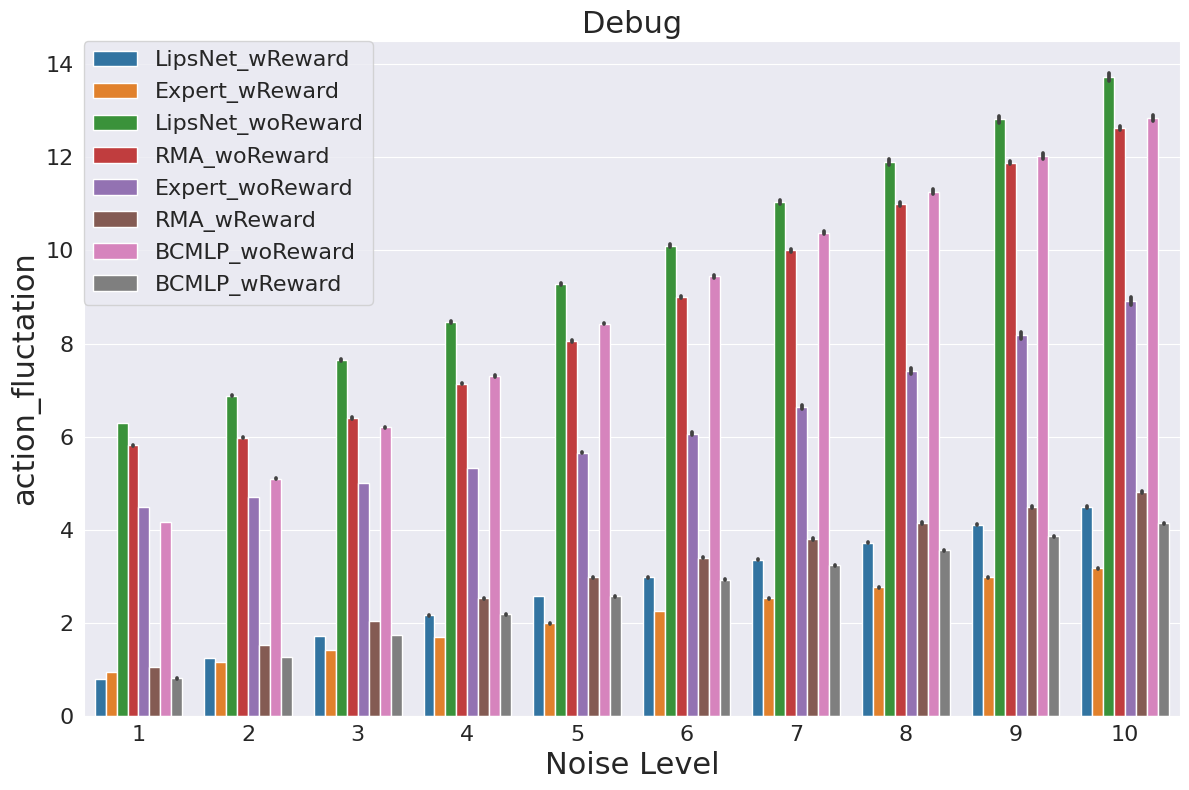

In [51]:
plot_df(
    uniformV05_data,
    y_name = 'action_fluctation',
    x_name = 'noise level',
    hue_name = 'name',
    save_path=None,
    y_label='action_fluctation',
    x_label='Noise Level',
    title="Debug",
    plot_type = 'bar'
)